In [38]:
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, 
from sklearn.datasets import load_iris, make_moons
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

X, Y = load_iris().data, load_iris().target

In [7]:
class RandomForestClassifier:
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, max_features='auto'):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split=2
        self.max_features = max_features
        self.trees_feat_idx = []
        
    def _get_trees(self):
        """
        Method creates trees used for classification. Hyperparameters for 
        all trees are the same and they have to be already set. Currently
        only max_depth and min_samples_split is used.
        
        Returns
        -------
        list
            Instances of DecisionTreeClassifiers 
            number of trees = self.n_estimators
        """
        trees = []
        for _ in range(self.n_estimators):
            trees.append(
                DecisionTreeClassifier(max_depth=self.max_depth, 
                                       min_samples_split=self.min_samples_split))
        return trees
    
    def _get_max_features(self, X):
        """
        Method is used for calculating number of max features used
        for predicting for one tree. There are a lot of different ways
        to calculate that. Most popular method (recommended in original
        paper) is sqrt(max_features). Additionally you can set just
        a number.
        
        Parameters
        ----------
        X : DataFrame
            Features for modelling
        
        Returns
        -------
        int
            number of features to take from X.
        """
        n_features = X.shape[1]
        if self.max_features == 'auto':
            return int(np.sqrt(n_features))
        elif isinstance(self.max_features, int):
            return max_features
        else:
            raise ValueError('Bad max features')
            
    def get_subset(self, X, Y):
        """
        When you use random forest algorithms it is important to use
        different subsets for traing trees. Doing that helps to 
        lower correlation between trees and as a result it decrease
        variance of the model.
        
        Parameters
        ----------
        X : DataFrame
            Features for modelling
        Y : Series
            targets
            
        Returns
        -------
        list
            subset of X and Y
        """
        m = X.shape[0]
        idx = np.random.choice(range(m), 10)
        return X[idx], Y[idx]
        
        
    def fit(self, X, Y):
        self.trees = self._get_trees()
        max_feat = self._get_max_features(X)
        m = X.shape[0]
        
        for i in range(self.n_estimators):
            sub_X, sub_Y = self.get_subset(X, Y)
            idx_features = np.random.choice(range(sub_X.shape[1]), max_feat, replace=True)
            self.trees_feat_idx.append(idx_features)
            temp_X = sub_X[:, idx_features]
            self.trees[i].fit(temp_X, sub_Y)
            
            
    def predict(self, X):
        y_preds = np.zeros(shape=(X.shape[0], self.n_estimators))
        for i in range(self.n_estimators):
            idx_features = self.trees_feat_idx[i]
            temp_X = X[:, idx_features]
            one_pred = self.trees[i].predict(temp_X)
            y_preds[:,i] = one_pred
        
        result = []
        for row in y_preds:
            pred = Counter(row).most_common(1)[0][0]
            result.append(pred)
        
        return result

In [8]:
one = X[:, 0].reshape(-1,1).tolist()
two = X[:, 1].reshape(-1,1).tolist()

In [9]:
model = RandomForestClassifier(max_depth=5)
model.fit(X, Y)
Y_pred = model.predict(X)

### Visualization of Random Forest

Accuracy score:  0.878


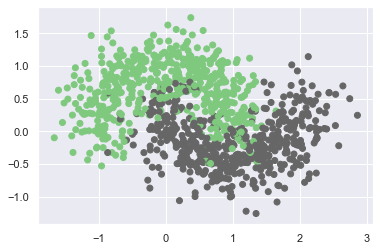

In [41]:
X, Y = make_moons(n_samples=1000, noise=0.3, random_state=42)
model = RandomForestClassifier(max_depth=5)
model.fit(X, Y)
Y_pred = model.predict(X)
print('Accuracy score: ', accuracy_score(Y, Y_pred))
plt.scatter(X[:,0], X[:,1], c=Y, cmap='Accent');